# Fake News

## Introduction

In this project we will look to to build a model to classify news as fake or true. As a hypothetical business scenario, we are working on a consulting assignment for a social media platform who has reported an influx of fake news. 

The rise of fake news is causing the company signficant concern as it could lead to a decline in user engagement not to mention the potential reputational damage for any entity targetted by the fake news, which the platform could be seen as facilitating.

By using machine learning to detect fake news, new stories posted on the platform could be systematically checked and should the model predict them to be fake, they would be initially rejected.

## Load Data

### Import libraries

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import nltk

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize

import string 

from wordcloud import WordCloud,STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, plot_confusion_matrix

from sklearn.model_selection import train_test_split

from keras.preprocessing import text, sequence

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM,Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
import keras
import tensorflow

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Read data

The data was obtained from Kaggle - https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset.

Acknowledgements
* Ahmed H, Traore I, Saad S. “Detecting opinion spams and fake news using text classification”, Journal of Security and Privacy, Volume 1, Issue 1, Wiley, January/February 2018.
* Ahmed H, Traore I, Saad S. (2017) “Detection of Online Fake News Using N-Gram Analysis and Machine Learning Techniques. In: Traore I., Woungang I., Awad A. (eds) Intelligent, Secure, and Dependable Systems in Distributed and Cloud Environments. ISDDC 2017. Lecture Notes in Computer Science, vol 10618. Springer, Cham (pp. 127-138).

In [2]:
# Read fake news csv
fake = pd.read_csv('../input/fake-and-real-news-dataset/Fake.csv')
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [3]:
# Read true news csv
true = pd.read_csv('../input/fake-and-real-news-dataset/True.csv')
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


Let us now add labels to the DataFrames, a `1` for true news and `0` for fake news.

In [4]:
# Add binary label column
fake['label'] = 0
true['label'] = 1

We now merge the two DataFrames.

In [5]:
# Merge using pd.concat
df = pd.concat([true, fake], ignore_index = True)
df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


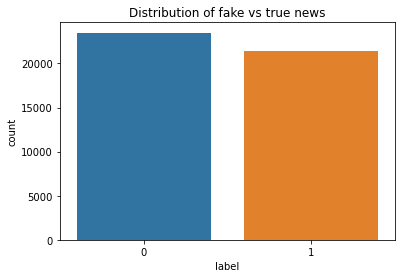

In [6]:
# Visualise class distribution
sns.countplot(df.label)
plt.title('Distribution of fake vs true news')
plt.show()

The dataset is balanced.

## Clean Data

### Investigate missing values

In [7]:
# Get info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [8]:
# Check missing values
df.isna().any().any()

False

There does not appear to be any missing values.

### Investigate duplicates

In [9]:
titlecounts = df.title.value_counts()
titlecounts

Factbox: Trump fills top jobs for his administration                                                     14
Factbox: Contenders for senior jobs in Trump's administration                                             8
Highlights: The Trump presidency on April 13 at 9:30 P.M. EDT/0130 GMT on Friday                          8
MEDIA IGNORES Time That Bill Clinton FIRED His FBI Director On Day Before Vince Foster Was Found Dead     6
Factbox: International reaction to arrest of Reuters reporters in Myanmar                                 6
                                                                                                         ..
French ministers tell anti-graft agency: no law revamp for now                                            1
U.S. Senate set to approve $1.1 billion in Zika virus funding                                             1
U.S. senator was told of link between Iran sanctions, prisoners                                           1
Iran rejects Macron call for

In [10]:
# Get duplicate titles which occured more than once
len(titlecounts[titlecounts>1])

5629

There are 5629 entries with the same title.

In [11]:
# Investigate most popular title
toptitledf = df[df['title'] == 'Factbox: Trump fills top jobs for his administration']
toptitledf.head()

,title,text,subject,date,label
6220,Factbox: Trump fills top jobs for his administ...,(Reuters) - U.S. President-elect Donald Trump ...,politicsNews,"January 19, 2017",1
6394,Factbox: Trump fills top jobs for his administ...,(Reuters) - U.S. President-elect Donald Trump ...,politicsNews,"January 11, 2017",1
6615,Factbox: Trump fills top jobs for his administ...,(Reuters) - U.S. President-elect Donald Trump ...,politicsNews,"December 21, 2016",1
6637,Factbox: Trump fills top jobs for his administ...,(Reuters) - President-elect Donald Trump will ...,politicsNews,"December 19, 2016",1
6655,Factbox: Trump fills top jobs for his administ...,(Reuters) - President-elect Donald Trump will ...,politicsNews,"December 17, 2016",1


In [12]:
len(df)

44898

We will drop duplicate rows.

In [13]:
df = df.drop_duplicates()
len(df)

44689

We will drop rows with same title and text (keeping the first instance.)

In [14]:
df = df.drop_duplicates(['title', 'text'])
len(df)

39105

We will also drop rows with exact same text (keeping the first instance.)

In [15]:
df = df.drop_duplicates(['text'])
len(df)

38646

### Investigate date

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38646 entries, 0 to 44119
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    38646 non-null  object
 1   text     38646 non-null  object
 2   subject  38646 non-null  object
 3   date     38646 non-null  object
 4   label    38646 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.8+ MB


Let us begin by checking whether all data in the `date` column is of the correct type and can be converted to a DateTime object.

In [17]:
try:
    df['date'] = pd.to_datetime(df['date'])
except ValueError:
    print('Values cannot be converted to DateTime')

Values cannot be converted to DateTime


Let us create a function which extracts the entries in `date` which are not a date.

In [18]:
def is_date(string):
    '''
    Checks if a string can be converted into a datetime object.
    Arguments:
    - string
    Returns:
    - True if can be converted to DateTime object
    - False otherwise
    '''
    try:
        date = pd.to_datetime(string)
        return True
    except ValueError:
        return False

In [19]:
# Apply function
df = df[df['date'].apply(is_date)]
df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [20]:
len(df)

38640

In [21]:
# Convert to date
df['date'] = pd.to_datetime(df['date'])
df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,1


In [22]:
# Describe date
df['date'].describe()

count                   38640
unique                   1010
top       2017-12-06 00:00:00
freq                      177
first     2015-03-31 00:00:00
last      2018-02-19 00:00:00
Name: date, dtype: object

The dataset description stated that the entries were from 2016 to 2017. As such let us investigate the early and later entries. 

In [23]:
df_early = df[df.date < pd.to_datetime('2016-01-01')]
df_early.head()

,title,text,subject,date,label
36146,EVERY U.S. CITIZEN TAKEN HOSTAGE IN IRAN To Be...,Just another slap in the face to US citizens. ...,politics,2015-12-31,0
36147,WATCH FUNNIEST MAN In American Politics Ridicu...,You don t want to miss this!Here s a little in...,politics,2015-12-31,0
36148,"FBI POSTS $5,000 REWARD For Person Who Committ...","Americans were warned by Attorney General, Lor...",politics,2015-12-31,0
36149,SWISS ARMY CHIEF WARNS CITIZENS About Explosiv...,Wouldn t it be great if we had someone in gove...,politics,2015-12-31,0
36150,WOW! Sarah Palin’s Stunning AZ Vacation Home G...,"It would be great if her former running mate,...",politics,2015-12-30,0


In [24]:
df_early['label'].value_counts()

0    1597
Name: label, dtype: int64

The entries prior to 01/01/2016 are all fake.

In [25]:
df_late = df[df.date > pd.to_datetime('2017-12-31')]
df_late.head()

,title,text,subject,date,label
30467,Democrat Senator Warns Mueller Not To Release ...,"According to The Hill, Democrat Senator Bob Ca...",politics,2018-02-19,0
30468,MSNBC ANCHOR Flabbergasted at What Texas Teach...,If we protect every other government building ...,politics,2018-02-19,0
30469,WATCH: SNOWFLAKES ASKED Communist Party Platfo...,Ami Horowitz is fantastic! Check out this man ...,politics,2018-02-19,0
30470,JUST IN: BADASS GENERAL JOHN KELLY Shoved Chin...,Just one more reminder of why President Trump ...,politics,2018-02-18,0
30471,DOJ’s JEFF SESSIONS Opens Investigation Into W...,Thank goodnesss Jeff Sessions is moving on fin...,politics,2018-02-18,0


In [26]:
df_late['label'].value_counts()

0    35
Name: label, dtype: int64

The entries after 31/12/17 are all fake.

## Initial EDA

Let's create a function to visualise the distribution of a given feature, split by label.

In [27]:
# Create helper function for plotting
def hist_plot_per_label(df, column, title):
    '''
    Displays histogram plot for a given column, split by label.
    Arguments:
    - df, Pandas dataframe
    - column, column to plot
    - title, string
    Returns: None
    '''
    plt.figure(figsize = (15,7))
    df[df['label'] == 1][column].hist(label='True')
    df[df['label'] == 0][column].hist(alpha=0.4, label='Fake')
    plt.title(title)
    plt.legend()
    plt.show()

### Label distribution

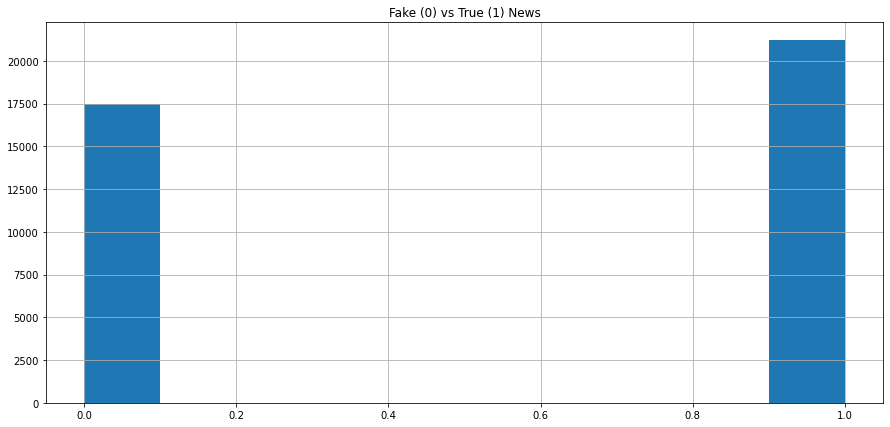

In [28]:
# Plot label distribution
plt.figure(figsize = (15, 7))
df['label'].hist()
plt.title('Fake (0) vs True (1) News')
plt.show()

### Label distribution over time

Let us look at the distribution of true/ fake news over time.

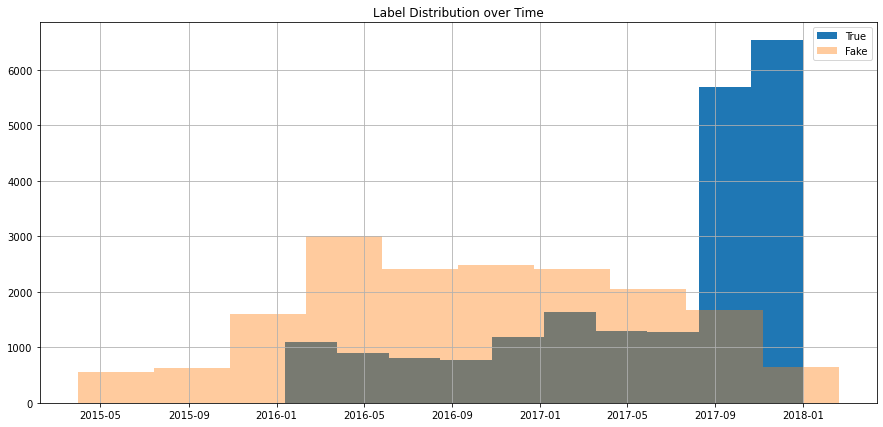

In [29]:
hist_plot_per_label(df, 'date', 'Label Distribution over Time')

We see a spike in true news between September 2017 and January 2018.

### Title Length

We wonder whether the length of the title varies between true or fake news.

In [30]:
# Add title length column
df['len_title'] = df['title'].apply(len)

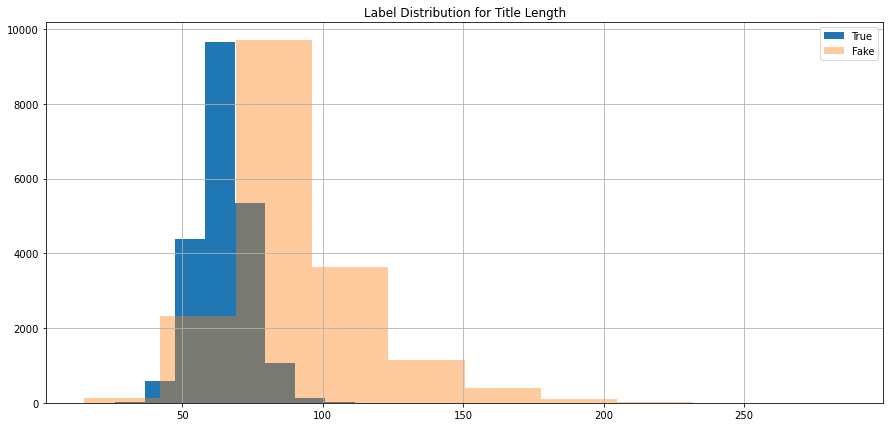

In [31]:
# Visualise
hist_plot_per_label(df, 'len_title', 'Label Distribution for Title Length')

In [32]:
# Describe title length for fake news
df[df['label'] == 0]['len_title'].describe()

count    17448.000000
mean        91.217274
std         24.504809
min         15.000000
25%         77.000000
50%         88.000000
75%        100.000000
max        286.000000
Name: len_title, dtype: float64

In [33]:
# Describe title length for true news
df[df['label'] == 1]['len_title'].describe()

count    21192.000000
mean        64.658598
std          9.162600
min         26.000000
25%         59.000000
50%         64.000000
75%         70.000000
max        133.000000
Name: len_title, dtype: float64

Higher variance for fake news, with std of 24. 

Also higher mean for fake news, with 91 characters vs 64 characters for true news.

### Text Length

In [34]:
# Add text length column
df['len_text'] = df['text'].apply(len)

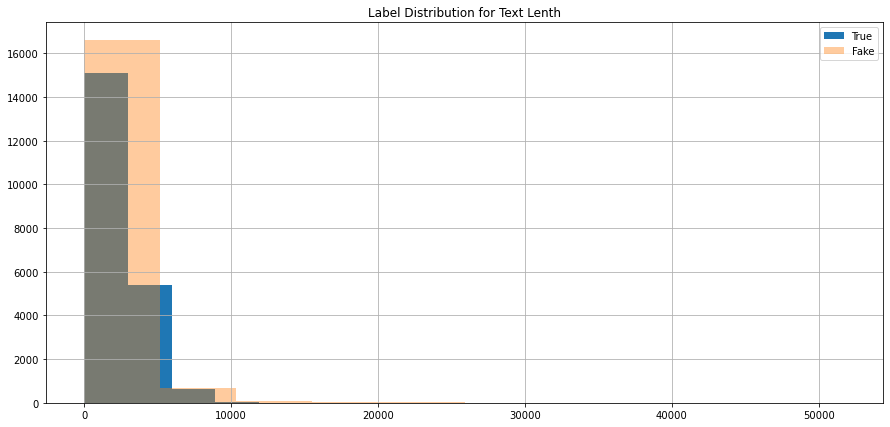

In [35]:
# Visualise
hist_plot_per_label(df, 'len_text', 'Label Distribution for Text Lenth')

In [36]:
# Describe text length for fake news
df[df['label'] == 0]['len_text'].describe()

count    17448.000000
mean      2550.766850
std       2201.245177
min          2.000000
25%       1650.000000
50%       2235.000000
75%       3006.000000
max      51794.000000
Name: len_text, dtype: float64

In [37]:
# Describe text length for true news
df[df['label'] == 1]['len_text'].describe()

count    21192.000000
mean      2378.414968
std       1683.821142
min          1.000000
25%        906.000000
50%       2216.000000
75%       3226.250000
max      29781.000000
Name: len_text, dtype: float64

Overall similar distribution.

### Presence of Capitals

In [38]:
# Create column to count number of capitals in title
df['caps_title'] = df['title'].apply(lambda x : sum(1 for char in x if char.isupper()))

# Check
df.head()

,title,text,subject,date,label,len_title,len_text,caps_title
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,1,64,4659,4
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,1,64,4077,4
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,1,60,2789,7
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,1,59,2461,8
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,1,69,5204,4


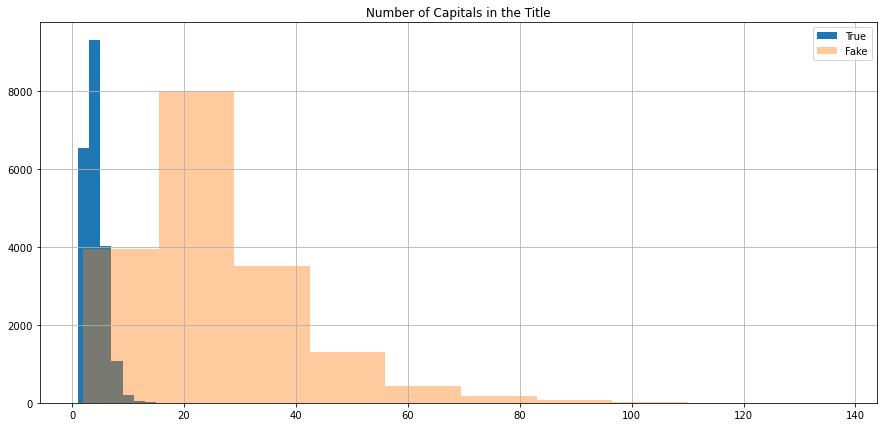

In [39]:
# Visualise
hist_plot_per_label(df, 'caps_title', 'Number of Capitals in the Title')

In [40]:
# Describe number of capitals in title for fake news
df[df['label'] == 0]['caps_title'].describe()

count    17448.000000
mean        25.689707
std         13.981860
min          2.000000
25%         16.000000
50%         22.000000
75%         32.000000
max        137.000000
Name: caps_title, dtype: float64

In [41]:
# Describe number of capitals in title for true news
df[df['label'] == 1]['caps_title'].describe()

count    21192.000000
mean         3.546102
std          1.783488
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         21.000000
Name: caps_title, dtype: float64

There are considerably more capitals in the title when looking at fake news.

Let us look at capitals in the text now.

In [42]:
# Create column to count number of capitals in title
df['caps_text'] = df['text'].apply(lambda x : sum(1 for char in x if char.isupper()))

# Check
df.head()

,title,text,subject,date,label,len_title,len_text,caps_title,caps_text
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,1,64,4659,4,155
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,1,64,4077,4,119
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,1,60,2789,7,117
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,1,59,2461,8,110
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,1,69,5204,4,200


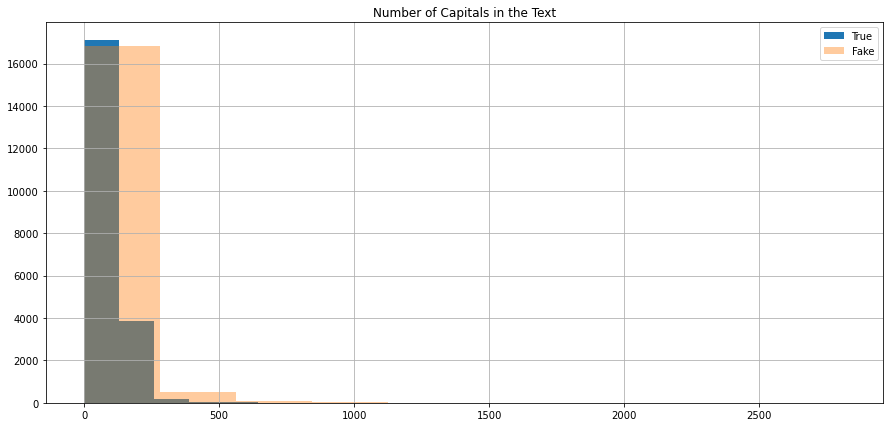

In [43]:
# Visualise
hist_plot_per_label(df, 'caps_text', 'Number of Capitals in the Text')

In [44]:
# Describe number of capitals in text for fake news
df[df['label'] == 0]['caps_text'].describe()

count    17448.000000
mean       101.091988
std         96.818908
min          0.000000
25%         56.000000
50%         80.000000
75%        116.000000
max       2818.000000
Name: caps_text, dtype: float64

In [45]:
# Describe number of capitals in text for true news
df[df['label'] == 1]['caps_text'].describe()

count    21192.000000
mean        87.348716
std         61.473809
min          0.000000
25%         41.000000
50%         76.000000
75%        115.000000
max       1291.000000
Name: caps_text, dtype: float64

Similar distribution.

### Investigate subject

In [46]:
# Get value counts
df['subject'].value_counts()

politicsNews       11214
worldnews           9978
News                9050
politics            6419
US_News              783
left-news            682
Government News      514
Name: subject, dtype: int64

Lets see the split between true/ fake news.

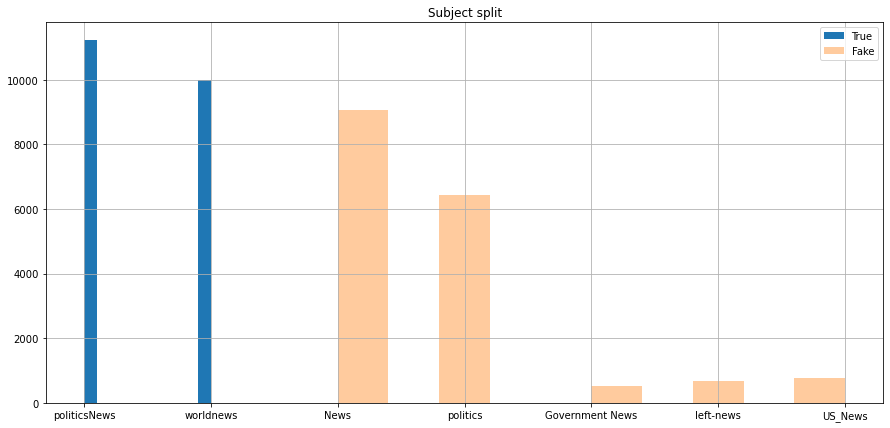

In [47]:
# Visualise
hist_plot_per_label(df, 'subject', 'Subject split')

As the subjects are different for true/ fake news we will exclude it from our analysis.

## Preprocessing

We will merge the title and text columns to create a unique feature column for our model.

In [48]:
# Create a copy
df_clean = df.copy()

# Create new text column which includes title
df_clean['text'] = df_clean['text'] + " " + df_clean['title']

# Unecessary cols
cols = ['title', 'subject', 'date', 'len_title', 'len_text', 'caps_title', 'caps_text']

# Drop unwanted columns
df_clean = df_clean.drop(cols, axis = 1)

# Check
df_clean.head()

,text,label
0,WASHINGTON (Reuters) - The head of a conservat...,1
1,WASHINGTON (Reuters) - Transgender people will...,1
2,WASHINGTON (Reuters) - The special counsel inv...,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


We will use `BeautifulSoup` to remove urls and create a function that does so for reusability.

In [49]:
# Define function to remove html
def remove_html(text):
    soup = BeautifulSoup(text, 'html.parser')
    cleantext = soup.get_text()
    return cleantext

In [50]:
# Apply function
df_clean['text'] = df_clean['text'].apply(remove_html)

In [51]:
# Preview first entry
df_clean['text'][0][:2000]

'WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support educat

We will look to remove stopwords.

In [52]:
# Define stopwords
stop = set(stopwords.words('english'))

We will create a function which returns the text without stopwords.

In [53]:
# Define function to remove stopwords
def remove_stopwords(text):
    words = []
    for word in text.split():
        if word.strip().lower() not in stop:
            words.append(word.strip())
    cleantext = " ".join(words)
    return cleantext

In [54]:
# Apply function to text
df_clean['text'] = df_clean['text'].apply(remove_stopwords)

In [55]:
# Preview first entry
df_clean['text'][0][:1000]

'WASHINGTON (Reuters) - head conservative Republican faction U.S. Congress, voted month huge expansion national debt pay tax cuts, called “fiscal conservative” Sunday urged budget restraint 2018. keeping sharp pivot way among Republicans, U.S. Representative Mark Meadows, speaking CBS’ “Face Nation,” drew hard line federal spending, lawmakers bracing battle January. return holidays Wednesday, lawmakers begin trying pass federal budget fight likely linked issues, immigration policy, even November congressional election campaigns approach Republicans seek keep control Congress. President Donald Trump Republicans want big budget increase military spending, Democrats also want proportional increases non-defense “discretionary” spending programs support education, scientific research, infrastructure, public health environmental protection. “The (Trump) administration already willing say: ‘We’re going increase non-defense discretionary spending ... 7 percent,’” Meadows, chairman small influe

Next we will remove punctuation.

In [56]:
# Define punctuation
punctuation = list(string.punctuation)
punctuation.append("“")
punctuation.append("”")
punctuation.append("’")

In [57]:
# Define function to remove punctuation
def remove_punctuation(text):
    no_punct = ""
    for char in text:
        if char not in punctuation:
            no_punct += char
    return no_punct

In [ ]:
# Apply function to text
df_clean['text'] = df_clean['text'].apply(remove_punctuation)

In [ ]:
# Preview first entry
df_clean['text'][0][:1000]

We will save the cleaned dataset as a `.csv` file.

In [ ]:
df_clean.to_csv('../data_clean.csv')

## Further EDA

### Word Clouds

Let us create Word Clouds for both true and fake news.

In [ ]:
# Plot Word Cloud for true news
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df_clean[df_clean.label == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

In [ ]:
# Plot Word Cloud for fake news
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df_clean[df_clean.label == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

### Analysing N-grams

We will now look at n-grams and focus on unigrams, bigrams and trigrams.

In [ ]:
# Define function to get corpus in each words
def get_corpus(text):
    words = []
    for item in text:
        for char in item.split():
            words.append(char.strip())
    return words

In [ ]:
# Apply function
corpus = get_corpus(df_clean['text'])
# View first few entries
corpus[:5]

In [ ]:
# Use Counter fo find most common words
counter = Counter(corpus)

# Find top 10
common = counter.most_common(10)

# Make dictionary
common = dict(common)

# Show common
common

In [ ]:
# Define function to get top n-grams

def get_top_ngrams(corpus, n, k):
    '''
    Inputs:
    Corpus - text
    n - n-gram number, univariate/ bivariate etc
    k - number of items to return
    '''
    vec = CountVectorizer(ngram_range = (n, n)).fit(corpus)
    bow = vec.transform(corpus)
    sumwords = bow.sum(axis = 0)
    wordfreq = [(word, sumwords[0, index]) for word, index in vec.vocabulary_.items()]
    wordfreq =sorted(wordfreq, key = lambda x: x[1], reverse=True)
    return wordfreq[:k]

Let's start by exploring unigrams, by setting `n` to be 1.

In [ ]:
# Get unigrams
uni = get_top_ngrams(df_clean['text'], n=1, k=10)
uni = dict(uni)
uni

In [ ]:
# Plot barchart
plt.figure(figsize = (10,6))
sns.barplot(x=list(uni.values()),y=list(uni.keys()))
plt.title('Top Unigrams')
plt.show()

Now let's look at bigrams.

In [ ]:
# Get bigrams
bigrams = get_top_ngrams(df_clean['text'], n=2, k=10)
bigrams = dict(bigrams)
bigrams

In [ ]:
# Plot barchart
plt.figure(figsize = (10,6))
sns.barplot(x=list(bigrams.values()),y=list(bigrams.keys()))
plt.title('Top Bigrams')
plt.show()

Finally let's look at trigrams.

In [ ]:
# Get trigrams
trigrams = get_top_ngrams(df_clean['text'], n=3, k=10)
trigrams = dict(trigrams)
trigrams

In [ ]:
# Plot barchart
plt.figure(figsize = (10,6))
sns.barplot(x=list(trigrams.values()),y=list(trigrams.keys()))
plt.title('Top Trigrams')
plt.show()

## Modelling

### Train test split

In [ ]:
# Perform train/test split
X_train, X_test, y_train, y_test = train_test_split(df_clean['text'], 
                                                    df_clean['label'], 
                                                    test_size = 0.2,
                                                    random_state = 0)

### Tokenizing

In [ ]:
# Set max_feat and maxlen
max_features = 10000
maxlen = 300

In [ ]:
# Instantiate and fit tokenizer
tokenizer = text.Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(X_train)

# Apply to trainset
X_train_tokenized = tokenizer.texts_to_sequences(X_train)
X_train_tokenized = sequence.pad_sequences(X_train_tokenized, maxlen = maxlen)

# Apply to testset
X_test_tokenized = tokenizer.texts_to_sequences(X_test)
X_test_tokenized = sequence.pad_sequences(X_test_tokenized, maxlen = maxlen)

In [ ]:
# Preview
X_train_tokenized[0]

### GloVe embeddings

GloVe is an algorithm for obtaining word vectors which focussed on the global relationship between words by building a word-word co-occurence matrix to derive relationships from.

In [ ]:
# Get pre-trained word vectors
twitter_file = '../input/glovetwitter27b100dtxt/glove.twitter.27B.100d.txt' 

In [ ]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')

# Create dictionary
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(twitter_file))

In [ ]:
# Get embeddings
embeddings = np.stack(embeddings_index.values())

# Get mean
embeddings_mean = embeddings.mean()

# Get standard deviation
embeddings_std = embeddings.std()

word_index = tokenizer.word_index

# Get number of words
numwords = min(max_features, len(word_index))

In [ ]:
# Size of embeddings
embeddings_size = embeddings.shape[1]

# Create embeddings matrix
embedding_matrix = np.random.normal(embeddings_mean, embeddings_std, (numwords, embeddings_size))

for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [ ]:
# Get shape
embedding_matrix.shape

### Training the model

In [ ]:
# Set parameters
batch_size = 256
epochs = 10
embeddingsize = 100

In [ ]:
# Learning rate
LR_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
# Define model
model = Sequential()

# Add embedding layer (non-trainable)
model.add(Embedding(max_features, 
                    output_dim = embeddingsize,
                    weights = [embedding_matrix],
                    input_length = maxlen,
                    trainable = False))

# Add other layers
model.add(LSTM(units = 128,
               return_sequences = True, 
               recurrent_dropout = 0.25,
               dropout = 0.25))

model.add(LSTM(units = 64,
               recurrent_dropout = 0.1,
               dropout = 0.1))

model.add(Dense(units = 42, activation = 'relu'))

model.add(Dense(units = 1, activation = 'sigmoid'))

In [ ]:
# Compile model
model.compile(optimizer = tensorflow.keras.optimizers.Adam(lr = 0.01), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
# Get summary
model.summary()

In [ ]:
# Fit model
history = model.fit(X_train_tokenized, 
                    y_train, 
                    batch_size = batch_size , 
                    validation_data = (X_test_tokenized, y_test) , 
                    epochs = epochs , 
                    callbacks = [LR_reduction])

### Model evaluation

In [ ]:
print("Accuracy Score (Training): " , model.evaluate(X_train_tokenized,y_train)[1]*100 , "%")
print("Accuracy Score (Test): " , model.evaluate(X_test_tokenized,y_test)[1]*100 , "%")

Let's visualise the accuracy and loss over the epochs.

In [ ]:
# Get values
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']
test_accuracy = history.history['val_accuracy']
test_loss = history.history['val_loss']

In [ ]:
xs = list(range(10))
plt.plot(xs, train_accuracy, 'go-', label = 'Train Accuracy')
plt.plot(xs, test_accuracy, 'ro-', label = 'Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

We see that the accuracy score remains roughly constant after 1 epoch, signifying that convergence has been achieved. We also note the similarity in results between train and test sets, signifying no overfitting.

In [ ]:
xs = list(range(10))
plt.plot(xs, train_loss, 'go-', label = 'Train Loss')
plt.plot(xs, test_loss, 'ro-', label = 'Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Similar to the previous visualising for accuracy, we note that loss stabilizes after the first epoch and is similar for both train and test sets.

In [ ]:
# Get predictions
preds = (model.predict(X_test_tokenized) > 0.5).astype("int32")

In [ ]:
# Print Classification report
print(classification_report(y_test, preds))

In [ ]:
# Get confusion matrix
conf_matrix = confusion_matrix(y_test, preds)
conf_matrix

In [ ]:
# Create confusion matrix plot

# Define DataFrame
cm = pd.DataFrame(conf_matrix , index = ['Fake','True'] , columns = ['Fake','True'])

# Create heatmap plot using Seaborn
plt.figure(figsize = (7,7))
sns.heatmap(cm, 
            cmap= "Blues", 
            linecolor = 'black' , 
            linewidth = 1 , 
            annot = True, 
            fmt='' , 
            xticklabels = ['Fake','True'] , 
            yticklabels = ['Fake','True'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Conclusion

Our model performed well, achieving an accuracy of 99.5% on unseen test data.

We would recommend the social media platform implement it to detect fake news.

### Future work

* Gather more data

Obtain news stories from other sources to train the model on a more varied range of stories. Consider news from social media platforms like Twitter as these would be more similar to that posted on the social media platform we have been engaged to work for.

* Explore transfer learning tools

Look for more transfer learning tools and advances in NLP to continue building and iterating on our model.